In [434]:
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm
from scipy.special import loggamma
from jax import vmap
from jax.scipy.special import j1

In [435]:
# Defining the relevant functions:

def mellin_wavelengths(wavelengths, weights, freqs):
    
    d_wl = (wavelengths[1]-wavelengths[0])

    prefac = 1/np.sqrt(2*np.pi)

    mellin = np.zeros_like(freqs, dtype=np.complex64)
    for idx, freq in enumerate(freqs):
        mel = np.sum(weights * wavelengths**(1j * freq - 1) * d_wl)
        mellin = mellin.at[idx].set(mel)

    mellin *= prefac
    return mellin

def h_kernel(freqs, diameter):
    logfisher = loggamma(1-1j*freqs/2) + loggamma(1/2 + 1j*freqs/2) - loggamma(1/2) - loggamma(3/2 - 1j*freqs/2) - loggamma(5/2 - 1j*freqs/2)

    prefac = (np.pi**(-1j*freqs) * diameter**(1-1j*freqs))/(2*np.sqrt(2*np.pi))

    fisher = np.exp(logfisher)

    fisher *= prefac
    return fisher

def polychrome_image_jax(r_coords, mellin_spec, h_hat, freqs):

    prefac = 1/(r_coords)# NO FACTOR OF sqrt2pi,,, cancels because unitary fourier transform convolution theorem * np.sqrt(2*np.pi))
    d_freq = freqs[1] - freqs[0]

    def single_poly(r):
        return np.sum(mellin_spec * h_hat * np.exp(-1.0j * freqs * np.log(r)) * d_freq)

    flat = vmap(single_poly)(r_coords.ravel())
    polychrome = flat.reshape(r_coords.shape) * prefac
    return polychrome

# this ben popes implimentation of the bessel func of first kind
def polyairydisk(r_coords, wavelengths, norm_weights, diameter):
    d_wl = wavelengths[1] - wavelengths[0]
    def single_wavelength(r):
        return np.sum(norm_weights * (1/wavelengths**2) * np.pi * diameter**2 * (j1(np.pi*diameter*r/wavelengths))**2/(np.pi*diameter*r/wavelengths)**2 * d_wl)
    
    flat = vmap(single_wavelength)(r_coords.ravel())
    polyairy = flat.reshape(r_coords.shape)

    return polyairy

# requires linearly spaced
def normalise_weights(wavelengths, weights):
    d_wl = wavelengths[1]- wavelengths[0]
    weights_norm = weights/(np.sum(weights)*d_wl)
    return weights_norm

# Defining inverse mellin
def inverse_mellin(freqs, melweights, wavelengths):
    prefac = 1/np.sqrt(2*np.pi)

    d_freq = freqs[1] - freqs[0]

    inv_mellin = np.zeros_like(wavelengths, dtype=np.complex64)
    for idx, wl in enumerate(wavelengths):
        inv_mel = np.sum(melweights * wl **(-1j*freqs) * d_freq)
        inv_mellin = inv_mellin.at[idx].set(inv_mel)

    inv_mellin *= prefac
    return inv_mellin

In [436]:
key = jr.PRNGKey(0)

psf_npixels = 16
oversample = 4
psf_pixel_scale = 0.375
diameter = 0.125

r_coords = dlu.pixel_coords(psf_npixels*oversample, dlu.arcsec2rad(psf_pixel_scale*psf_npixels),True)[0]

n_wavelengths = 500
min_wavelength = 500e-9
max_wavelength = 600e-9

wavelengths = np.linspace(min_wavelength,max_wavelength,n_wavelengths)
# just uniform random weights
weights = normalise_weights(wavelengths, jr.uniform(key, (n_wavelengths,)))

psf_analytic = polyairydisk(r_coords, wavelengths, weights, diameter)

# compare to mellin version
# define a maximum frequency
max_freq = 50
n_freqs = 300
freqs = np.linspace(-max_freq, max_freq, n_freqs)

melspec = mellin_wavelengths(wavelengths, weights, freqs)

# getting inverse mellin weights (for plotting)
# just gonna get some extra wavelengths dont mind me
delta_wavelengths = max_wavelength - min_wavelength
wavelengths_extra = np.linspace(min_wavelength-delta_wavelengths/2, max_wavelength+delta_wavelengths/2, 2*n_wavelengths)
inv_melweights = inverse_mellin(freqs, melspec, wavelengths_extra)

h_kern = h_kernel(freqs, diameter)

psf_mellin = polychrome_image_jax(r_coords, melspec, h_kern, freqs)

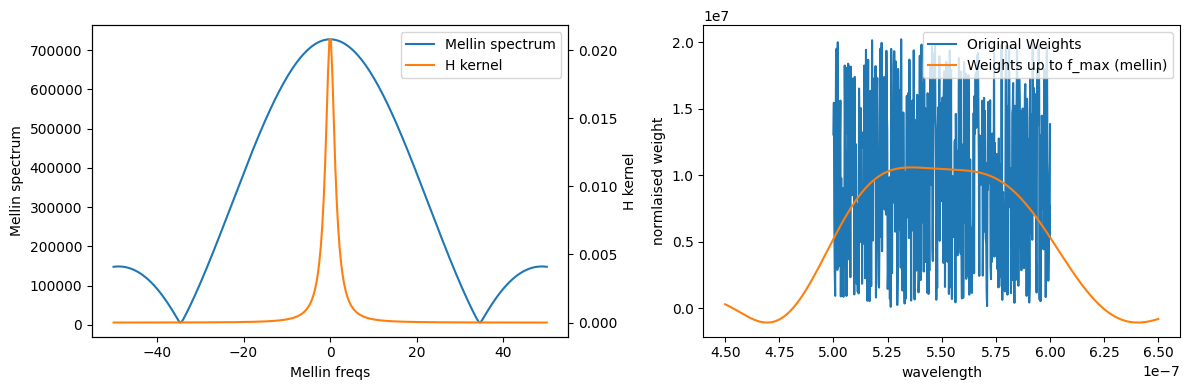

In [437]:
plt.figure(figsize=(12,4))
# Left subplot
ax1 = plt.subplot(1,2,1)
ax1.plot(freqs, np.abs(melspec), label='Mellin spectrum', color='C0')
ax1.set_ylabel("Mellin spectrum")

ax2 = ax1.twinx()  # second y-axis sharing same x
ax2.plot(freqs, np.abs(h_kern), label='H kernel', color='C1')
ax2.set_ylabel("H kernel")
# Optional: combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc="upper right")
ax1.set_xlabel('Mellin freqs')

plt.subplot(1,2,2)
plt.plot(wavelengths, weights, label='Original Weights')
plt.plot(wavelengths_extra, np.real(inv_melweights), label='Weights up to f_max (mellin)')
plt.legend()
plt.ylabel('normlaised weight')
plt.xlabel('wavelength')
plt.tight_layout()
plt.show()

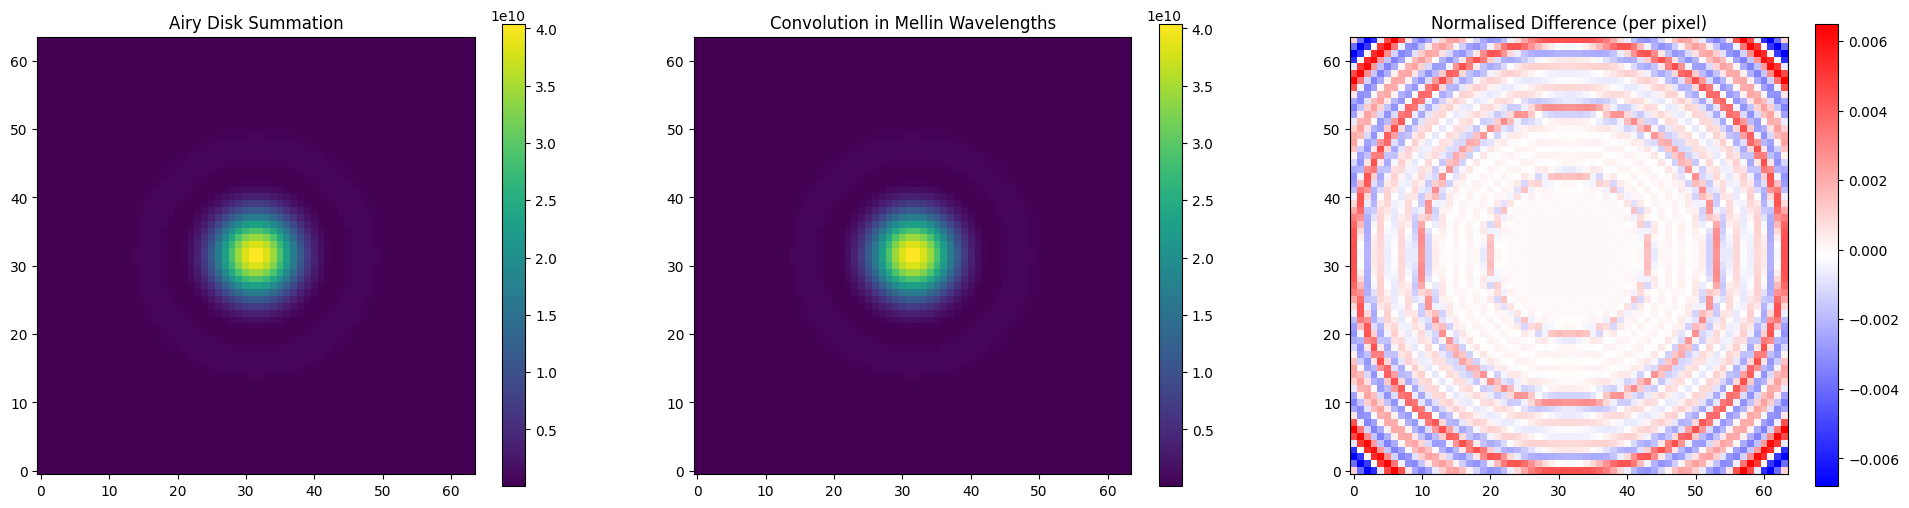

In [438]:
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.imshow(psf_analytic**1, origin='lower')
plt.colorbar()
plt.title('Airy Disk Summation')

plt.subplot(1,3,2)
plt.imshow(np.real(psf_mellin)**1, origin='lower')
plt.title('Convolution in Mellin Wavelengths')
plt.colorbar()

plt.subplot(1,3,3)
plt.title('Normalised Difference (per pixel)')
plt.imshow((np.real(psf_mellin) - psf_analytic)/psf_analytic, origin='lower', cmap='bwr')
plt.colorbar()
plt.show()

# Errors seem to expand as you go further and further out..  tragic
# Could just be going up against machine precision issues.

In [439]:
# let's try and do autodiff on the image
# unfortunately, gonna have to do least squares loss function, because otherwise i suspect negative weights will ruin everything
# yet, should still be ok hopefully.

# just realised: need noise


In [517]:
import optax
from jax import jit, value_and_grad
# radians to pixels
rad_to_pix = dlu.arcsec2rad(psf_pixel_scale/oversample)
# flux
# e12 is too high.. poisson breaks
# e5 has noticable zeros at this resolution
# e6 does have some, but not that bad
# choose flux values from e6 to e11
# and it conforms fairly well with the analytic crb
# at e11, lower learning rate
flux = 1e8

# --- model / forward -------------------------------------------------------
@jit
def polychrome_image_jax(r_coords, mellin_spec, h_hat, freqs):
    # r_coords: (H,W) or (N,)
    d_freq = freqs[1] - freqs[0]
    flat_r = r_coords.ravel()
    log_r = np.log(flat_r)               # ensure r>0 (avoid r=0)
    phasors = np.exp(-1.0j * np.outer(log_r, freqs))   # (N, F)
    contrib = (mellin_spec * h_hat * d_freq)             # (F,)
    flat = phasors @ contrib                             # (N,) complex
    polychrome = flat.reshape(r_coords.shape) / r_coords
    # convert to pixels
    polychrome *= rad_to_pix**2
    # add flux
    polychrome *= flux
    return polychrome

# --- loss ------------------------------------------------------------------
@jit
def loss_fn(params, r_coords, target, h_hat, freqs, l2=0.0, imag_weight=1.0):
    # params: {'real': ..., 'imag': ...}
    mellin_spec = params['real'] + 1j * params['imag']
    pred = polychrome_image_jax(r_coords, mellin_spec, h_hat, freqs)
    # ensure target is complex so subtraction yields complex dtype
    target_c = np.asarray(target, dtype=pred.dtype)
    mse = np.mean(np.abs(pred - target_c) ** 2)   # penalises imag part automatically
    # optional extra weight on imag component:
    if imag_weight != 1.0:
        real_mse = np.mean((np.real(pred) - np.real(target_c))**2)
        imag_mse = np.mean(np.abs(np.imag(pred))**2)
        mse = real_mse + imag_weight * imag_mse
    reg = l2 * np.sum(params['real']**2 + params['imag']**2)
    return mse + reg

# --- jitted training step --------------------------------------------------
# value_and_grad returns (loss, grads) where grads has same pytree structure as params
value_and_grad_loss = jit(value_and_grad(loss_fn))


# --- utilities for monitoring ---------------------------------------------
@jit
def imag_rms(params, r_coords, h_hat, freqs):
    mellin_spec = params['real'] + 1j * params['imag']
    pred = polychrome_image_jax(r_coords, mellin_spec, h_hat, freqs)
    return np.sqrt(np.mean(np.abs(np.imag(pred))**2))

# create optimizer once
optimizer = optax.adam(5e1)

@jit
def update_step(params, opt_state, r_coords, target, h_hat, freqs):
    loss, grads = value_and_grad_loss(params, r_coords, target, h_hat, freqs)
    updates, opt_state = optimizer.update(grads, opt_state, params)   # optimizer is closed over
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

def train(params, r_coords, target, h_hat, freqs, lr=1e-3, steps=1000, log_every=100):
    # if you want to change lr, recreate optimizer above (or recreate here and opt_state)
    opt_state = optimizer.init(params)
    for i in range(steps):
        params, opt_state, loss = update_step(params, opt_state, r_coords, target, h_hat, freqs)
        if i % log_every == 0:
            print(f"step {i} loss {float(loss):.6e}")
    return params

def train_and_record(params, opt_state, r_coords, target, h_hat, freqs,
                     steps=2000, record_every=1, log_every=100):
    losses = []
    imag_vals = []
    for i in range(steps):
        params, opt_state, loss = update_step(params, opt_state, r_coords, target, h_hat, freqs)
        if (i % record_every) == 0:
            # convert to Python floats (cheap)
            losses.append(float(loss))
            imag_vals.append(float(imag_rms(params, r_coords, h_hat, freqs)))
        if (i % log_every) == 0:
            print(f"step {i:5d}  loss {losses[-1]:.6e}  imag_rms {imag_vals[-1]:.3e}")
    return params, opt_state, np.array(losses), np.array(imag_vals)




# --- initialization example ------------------------------------------------
# make sure freqs, h_hat, r_coords, target exist and are jnp arrays
F = len(freqs)

melspec_guess = np.ones_like(melspec)*np.max(np.abs(melspec))/2        # complex

# DO THIS!!
melspec_guess = melspec

params = {
    'real': np.real(melspec_guess).astype(np.float32),
    'imag': np.imag(melspec_guess).astype(np.float32) # basically gonna start as 0
}

# flux, pixel conversion, etc.
# can choose between psf_analytic (bessel function sum) and psf_mellin (mellin conv.)
# psf mellin is probably most correct
target = jr.poisson(key, flux*rad_to_pix**2*np.real(psf_mellin))
h_hat = h_kern

opt_state = optimizer.init(params)
# run training and record every step (or e.g. every 10 steps to save memory)
record_every = 1   # try 10 if you want less memory / faster logging
params, opt_state, losses, imag_vals = train_and_record(params, opt_state, r_coords, target, h_hat, freqs,
                                                        steps=2000, record_every=record_every, log_every=100)

#trained = train(params, r_coords, target, h_hat, freqs, lr=10e5, steps=1000)


step     0  loss 2.129522e+04  imag_rms 3.217e-02
step   100  loss 1.987699e+04  imag_rms 8.731e-03
step   200  loss 1.973321e+04  imag_rms 8.617e-03
step   300  loss 1.964841e+04  imag_rms 8.694e-03
step   400  loss 1.959444e+04  imag_rms 6.408e-03
step   500  loss 1.955782e+04  imag_rms 5.267e-03
step   600  loss 1.953046e+04  imag_rms 8.634e-03
step   700  loss 1.950818e+04  imag_rms 7.715e-03
step   800  loss 1.948915e+04  imag_rms 6.456e-03
step   900  loss 1.947301e+04  imag_rms 9.427e-03
step  1000  loss 1.945811e+04  imag_rms 9.805e-03
step  1100  loss 1.944530e+04  imag_rms 7.918e-03
step  1200  loss 1.943377e+04  imag_rms 1.548e-02
step  1300  loss 1.942354e+04  imag_rms 5.565e-03
step  1400  loss 1.941430e+04  imag_rms 5.751e-03
step  1500  loss 1.940598e+04  imag_rms 2.651e-02
step  1600  loss 1.939904e+04  imag_rms 9.607e-03
step  1700  loss 1.939269e+04  imag_rms 1.397e-02
step  1800  loss 1.938689e+04  imag_rms 4.535e-02
step  1900  loss 1.938191e+04  imag_rms 1.923e-02


MSE (real part): 1.937749e+04
Imag RMS: 1.157041e-01


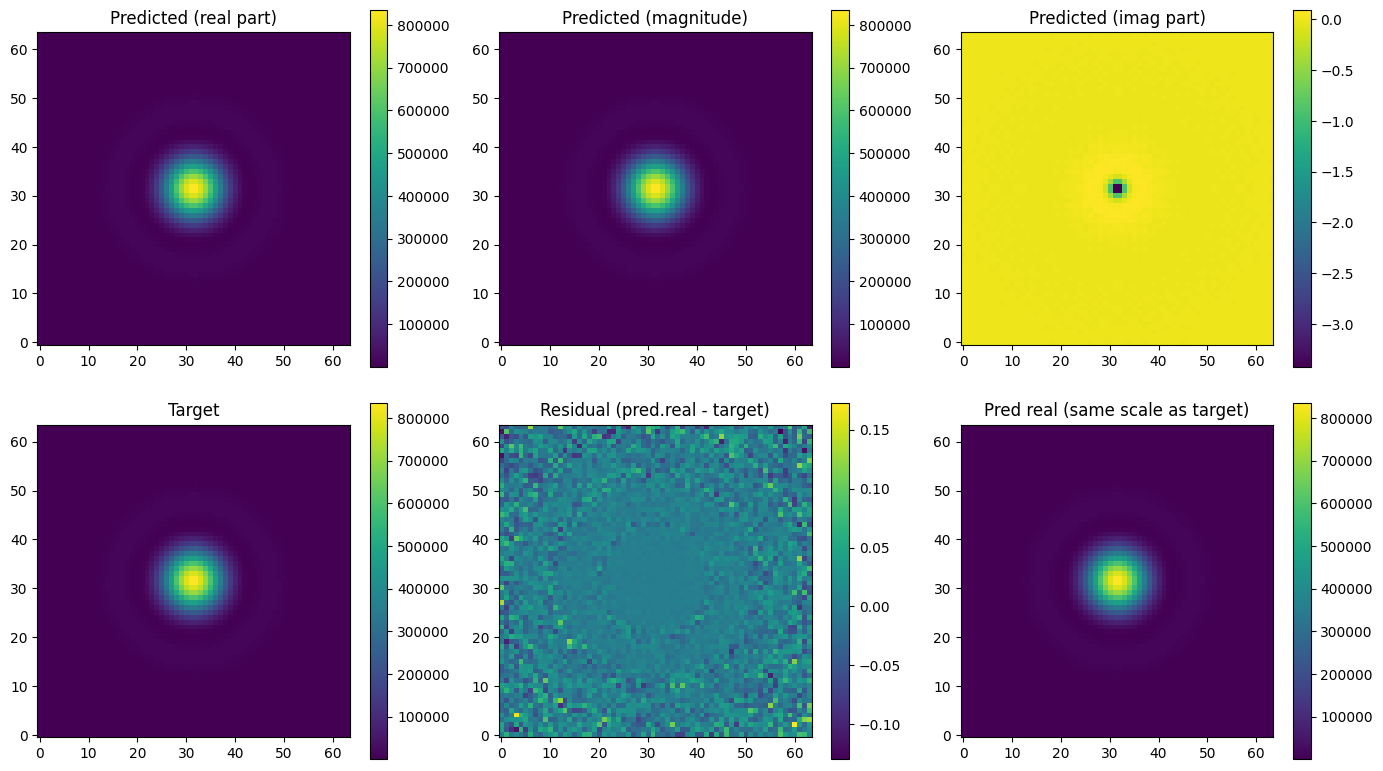

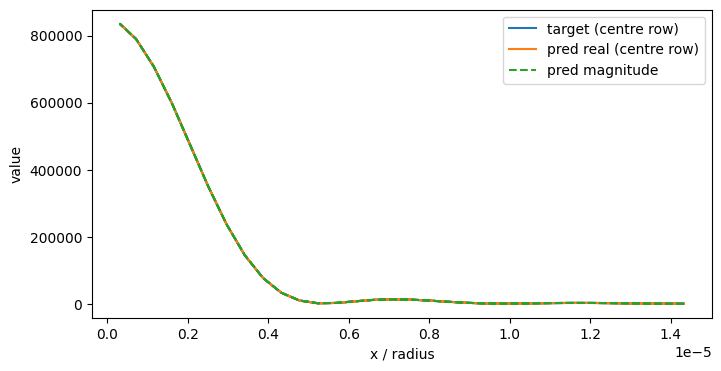

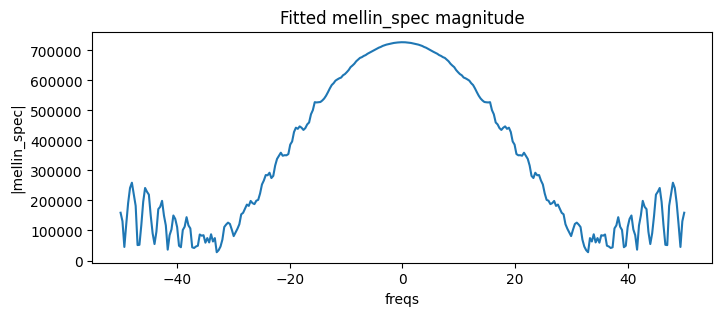

In [518]:
import matplotlib.pyplot as plt
import jax

# 1) Build the complex mellin_spec and compute prediction (on device)
mellin_spec = params['real'] + 1j * params['imag']
pred_complex = polychrome_image_jax(r_coords, mellin_spec, h_hat, freqs)  # jnp array (complex)

# 2) Move to host (numpy) for plotting
pred = jax.device_get(pred_complex)         # complex numpy array
mellin_spec_host = jax.device_get(mellin_spec)
target_host = jax.device_get(np.asarray(target))  # ensure target is array on host
r_coords_host = jax.device_get(r_coords)

# 3) Compute diagnostics
mse = np.mean(np.abs(pred.real - target_host)**2)
imag_rms = np.sqrt(np.mean(np.abs(pred.imag)**2))
print(f"MSE (real part): {mse:.6e}")
print(f"Imag RMS: {imag_rms:.6e}")

# 4) Show images: predicted real, predicted magnitude, imag, and residual
plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.imshow(pred.real, origin='lower')
plt.title("Predicted (real part)")
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(np.abs(pred), origin='lower')
plt.title("Predicted (magnitude)")
plt.colorbar()

plt.subplot(2,3,3)
plt.imshow(pred.imag, origin='lower')
plt.title("Predicted (imag part)")
plt.colorbar()

plt.subplot(2,3,4)
plt.imshow(target_host, origin='lower')
plt.title("Target")
plt.colorbar()

plt.subplot(2,3,5)
plt.imshow((pred.real - target_host)/target_host, origin='lower')
plt.title("Residual (pred.real - target)")
plt.colorbar()

# optional: zoom / same color scale for fair visual comparison
vmin = np.min(np.array([target_host.min(), pred.real.min()]))
vmax = np.max(np.array([target_host.max(), pred.real.max()]))
plt.subplot(2,3,6)
plt.imshow(pred.real, origin='lower', vmin=vmin, vmax=vmax)
plt.title("Pred real (same scale as target)")
plt.colorbar()

plt.tight_layout()
plt.show()

# 5) Plot a 1-D slice through the centre (useful for radially symmetric data)
H, W = target_host.shape
cy, cx = H // 2, W // 2
plt.figure(figsize=(8,4))
r_line = r_coords_host[cy, :] if r_coords_host.ndim == 2 else np.arange(W)
plt.plot(r_line, target_host[cy, :], label='target (centre row)')
plt.plot(r_line, pred.real[cy, :], label='pred real (centre row)')
plt.plot(r_line, np.abs(pred[cy, :]), '--', label='pred magnitude')
plt.legend()
plt.xlabel("x / radius")
plt.ylabel("value")
plt.show()

# 6) Plot the fitted mellin_spec magnitude vs freqs
plt.figure(figsize=(8,3))
plt.plot(np.array(freqs), np.abs(mellin_spec_host))
plt.xlabel("freqs")
plt.ylabel("|mellin_spec|")
plt.title("Fitted mellin_spec magnitude")
plt.show()


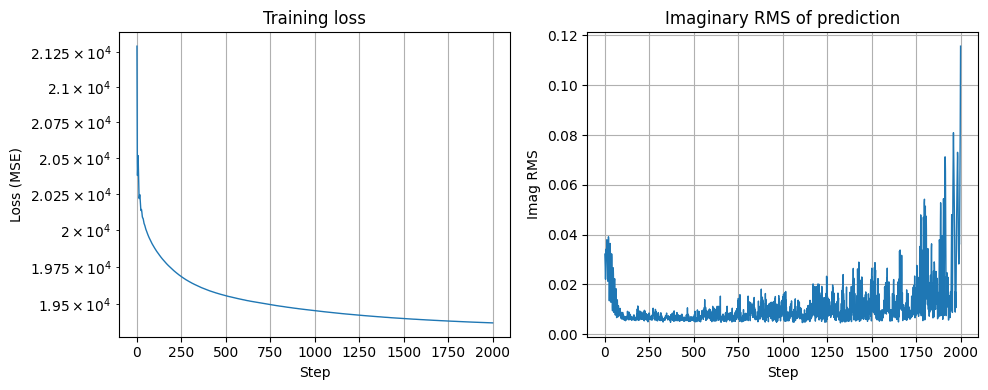

In [519]:
# ---------- plotting ----------
steps = np.arange(len(losses)) * record_every

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(steps, losses, '-', linewidth=1)
plt.yscale('log')               # often helpful for loss
plt.xlabel('Step')
plt.ylabel('Loss (MSE)')
plt.title('Training loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(steps, imag_vals, '-', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Imag RMS')
plt.title('Imaginary RMS of prediction')
plt.grid(True)

plt.tight_layout()
plt.show()


In [520]:
# fisher info
max_r = np.max(r_coords)

n_rs = 1024
# right so with small enough r this totally doesnt converge
# we will do from smallest radius to central pixel coordinate
min_r = np.min(r_coords)

rs_int = np.linspace(min_r,max_r,n_rs)

def inverse_nu_integral(rs_int, wavelengths, norm_weights, diameter):
    d_r = rs_int[1] - rs_int[0]

    inuint = np.sum(1/(rs_int*polyairydisk(rs_int, wavelengths, norm_weights, diameter)) * d_r)

    return inuint

inv_nu_int = inverse_nu_integral(rs_int, wavelengths, weights, diameter)

fisher_info = (2 * np.pi) * np.abs(h_kern)**2 * inv_nu_int * flux

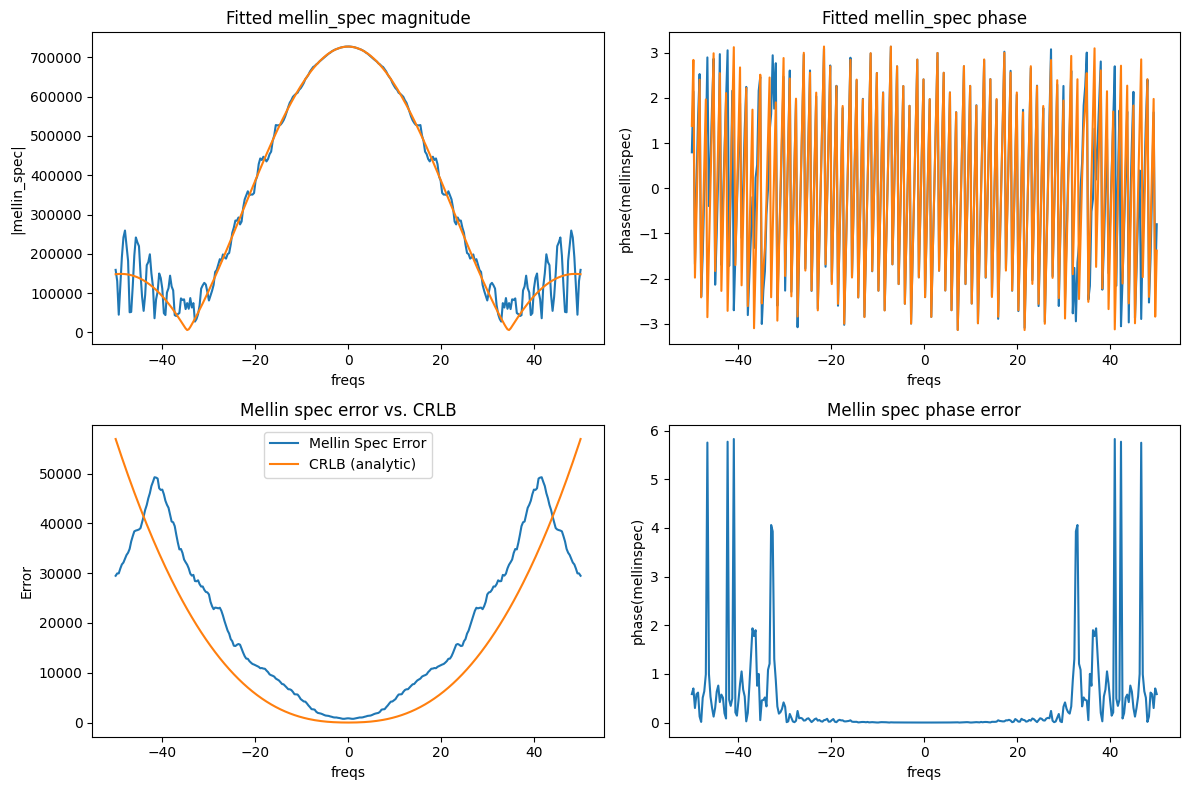

In [529]:
# 6) Plot the fitted mellin_spec magnitude vs freqs
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(np.array(freqs), np.abs(mellin_spec_host))
plt.plot(freqs, np.abs(melspec))
plt.xlabel("freqs")
plt.ylabel("|mellin_spec|")
plt.title("Fitted mellin_spec magnitude")

plt.subplot(2,2,2)
plt.plot(np.array(freqs), np.angle(mellin_spec_host))
plt.plot(freqs, np.angle(melspec))
plt.xlabel("freqs")
plt.ylabel("phase(mellinspec)")
plt.title("Fitted mellin_spec phase")

plt.subplot(2,2,3)
plt.plot(np.array(freqs), np.convolve(np.abs(np.abs(mellin_spec_host)-np.abs(melspec)),np.ones(51)/51 ,mode='same'),label='Mellin Spec Error')
plt.plot(freqs, 1/np.sqrt(fisher_info), label='CRLB (analytic)')
plt.xlabel("freqs")
plt.ylabel("Error")
plt.title("Mellin spec error vs. CRLB")
#plt.ylim(0,2.5*np.median(np.abs(np.abs(mellin_spec_host)-np.abs(melspec))))
plt.legend()

plt.subplot(2,2,4)
plt.plot(np.array(freqs), np.abs(np.angle(mellin_spec_host)-np.angle(melspec)))
plt.xlabel("freqs")
plt.ylabel("phase(mellinspec)")
plt.title("Mellin spec phase error")

plt.tight_layout()
plt.show()

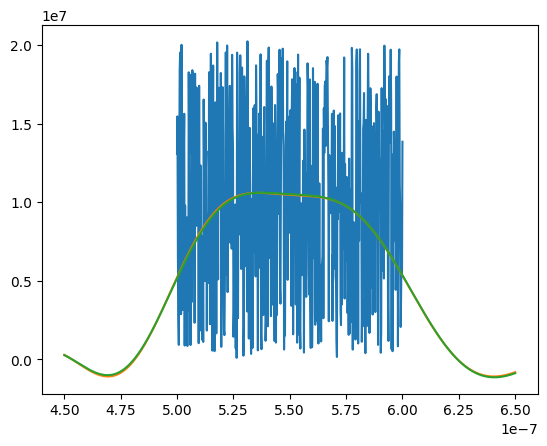

In [522]:
plt.plot(wavelengths,weights)
plt.plot(wavelengths_extra, np.real(inv_melweights))
plt.plot(wavelengths_extra,np.real(inverse_mellin(freqs,mellin_spec_host,wavelengths_extra)))

plt.show()

In [ ]:
# Sooo... uhhh... 
# this works.
# Next step: autodiff the hessian
# will give the actual definition of CRB. Should hopefully agree!!
# at this point though, might just be better to begin writing it up.
# autodiffing the hessian seems like exactly what you would do if you wanted to take advantage of autodiff.
# but it might be difficult.
# I guess the ultimate proof will be in the dispersed case. if it works in that case, then we can be more confident in the maths.